# **Abstract:**

Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients with age, color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.

This dataset is meant to represent ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. 
The aim of the motebook is to claasify the annotations labeled by trained human readers with quality control management into two labels including **normal and cataract.**

Various visualisation techniques such as **correlation matrix, pairplot** (bar plot) are implemented in the study of data distribution.

Deep learning model is implemented using **Keras and Tenson Flow**. Rectified linear unit (ReLU) is used as the activation function and **Binary cross entropy** is used as cost function. **ADAMN** is implemented for gradient descent.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from google.colab import drive
import cv2
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **READING CSV FILE**

In [4]:
# open csv file (note - target and filename only references one single eye)

df_data = pd.read_csv("/content/drive/MyDrive/DSEM/Ocular_disease/Ocular_Disease_dataset/full_df.csv")
df_data.head()




,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# **DISPLAY OF INFORMATION**

In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

# **CHECKING FOR CATARACT**
Display all rows whith coloumn C = 1

In [6]:

df_data[df_data.C==1].head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
20,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",24_right.jpg
65,81,66,Male,81_left.jpg,81_right.jpg,moderate non proliferative retinopathy，cataract,moderate non proliferative retinopathy，cataract,0,1,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",81_right.jpg
86,103,55,Female,103_left.jpg,103_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",103_right.jpg
93,112,57,Female,112_left.jpg,112_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",112_right.jpg


# **DISPLAY OF POSTIVE RESULTS IN THE DATASET**

In [7]:
#Find the number of positive "1" results in the dataset

df_data[df_data == 1].sum(axis=0)

ID                              2.0
Patient Age                    28.0
Patient Sex                     0.0
Left-Fundus                     0.0
Right-Fundus                    0.0
Left-Diagnostic Keywords        0.0
Right-Diagnostic Keywords       0.0
N                            2101.0
D                            2123.0
G                             397.0
C                             402.0
A                             319.0
H                             203.0
M                             306.0
O                            1588.0
filepath                        0.0
labels                          0.0
target                          0.0
filename                        0.0
dtype: float64

We found that relying on the encoded diagnosis categories "N D G C A H M O" could be problematic in the sense that some of the values were positive for both normal and disease eyes, but didn't specify which eye. The problem with this is that the files and diagnosis are orientation specific and the row of data contains both eyes information. If we use the categories exclusively, we run into the problem later on where pulling specific eye orientation data is impossible as it is lost in the encoded categories.

Therefore we will exclude those categories for this notebook although they could certainly be used for other investigations.

In [8]:
df_data2 = df_data.iloc[:, 1:7]
df_data2.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


# **Exploratory data analysis**

In [9]:
def plot_count(feature, title, df, size=1, show_all=False):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    if show_all:
        g = sns.countplot(df[feature], palette='Set3')
        g.set_title("{} distribution".format(title))
    else:
        g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set2')
        if(size > 2):
            plt.xticks(rotation=90, size=8)
            for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 0.2,
                        '{:1.2f}%'.format(100*height/total),
                        ha="center") 
        g.set_title("Number and percentage of {}".format(title))
    plt.show()  

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


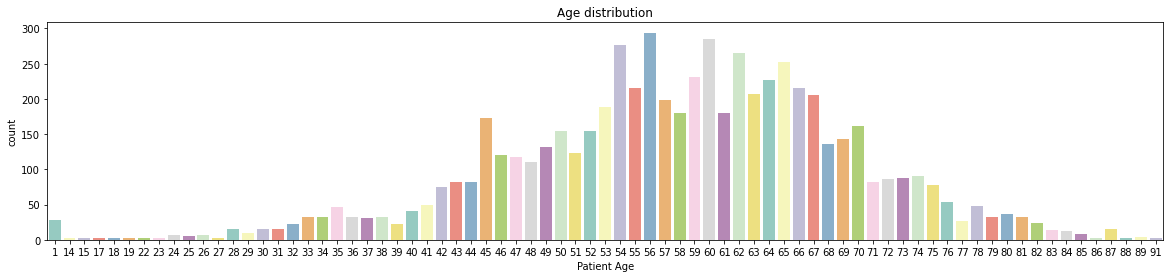

In [10]:
plot_count("Patient Age", "Age", df_data, size=5, show_all=True)

In [11]:
def plot_count(feature, title, df, size=1, show_all=False):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    if show_all:
        g = sns.countplot(df[feature], palette='Set3')
        g.set_title("{} distribution".format(title))
    else:
        g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set2')
        if(size > 2):
            plt.xticks(rotation=90, size=8)
            for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 0.2,
                        '{:1.2f}%'.format(100*height/total),
                        ha="center") 
        g.set_title("Number and percentage of {}".format(title))
    plt.show()    

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


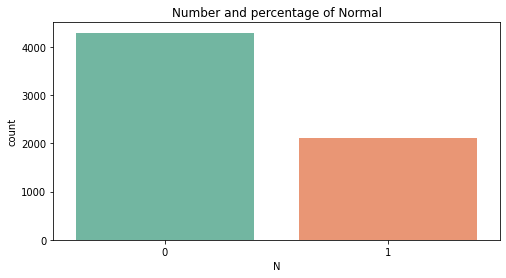

In [12]:
plot_count("N", "Normal", df_data, size=2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


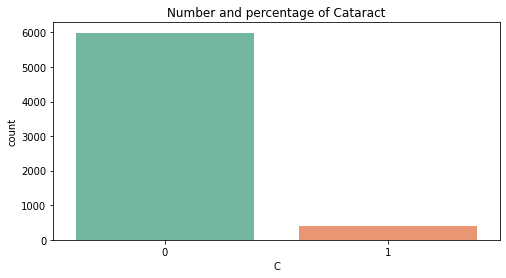

In [13]:
plot_count("C", "Cataract", df_data, size=2)

In [14]:
def plot_feature_distribution_grouped(feature, title, df, hue, size=4):
    plt.figure(figsize=(size*5,size*2))
    plt.title(title)
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    g = sns.countplot(df[feature], hue=df[hue], palette='Set1')
    plt.xlabel(feature)
    plt.legend()
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


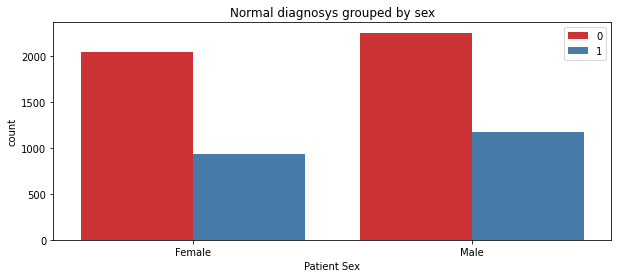

In [15]:
plot_feature_distribution_grouped('Patient Sex', 'Normal diagnosys grouped by sex', df_data, 'N', size=2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


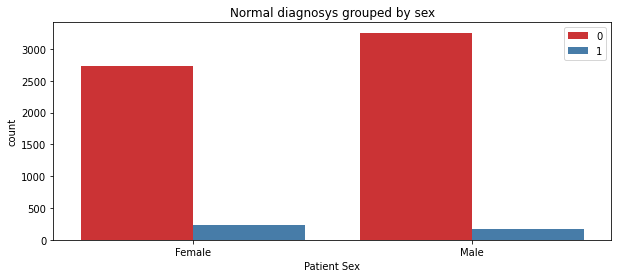

In [16]:
plot_feature_distribution_grouped('Patient Sex', 'Normal diagnosys grouped by sex', df_data, 'C', size=2)

## **Loading image dataset**

In [17]:
img_dir_train = "/content/drive/MyDrive/DSEM/Ocular_disease/Ocular_Disease_dataset/preprocessed_images"
img_dir_test = "/content/drive/MyDrive/DSEM/Ocular_disease/Ocular_Disease_dataset/ODIR-5K/Testing_Images"

# **SELECTION OF CATARCT ONLY DATA**

Left eye diagnosis with catract keyword

In [18]:

df_data2[df_data2['Left-Diagnostic Keywords'].str.match('cataract')].head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
86,55,Female,103_left.jpg,103_right.jpg,cataract,normal fundus
100,59,Male,119_left.jpg,119_right.jpg,cataract,drusen
218,60,Female,254_left.jpg,254_right.jpg,cataract,macular epiretinal membrane
256,69,Female,294_left.jpg,294_right.jpg,cataract,normal fundus


Placing the left cataract data into its own dataframe and printing the number of related rows

In [19]:

df_left_cat = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('cataract')]
print(len(df_left_cat))

294


Right diagnosis with 'cataract' keyword

In [20]:


df_data[df_data['Right-Diagnostic Keywords'].str.match('cataract')].head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
20,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",24_right.jpg
93,112,57,Female,112_left.jpg,112_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",112_right.jpg
160,188,55,Female,188_left.jpg,188_right.jpg,laser spot，severe proliferative diabetic retin...,cataract,0,1,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",188_right.jpg
186,218,36,Female,218_left.jpg,218_right.jpg,refractive media opacity,cataract,0,0,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",218_right.jpg
309,354,65,Male,354_left.jpg,354_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",354_right.jpg



Placing the right cataract data into its own dataframe and printing the number of related rows

In [21]:

df_rt_cat = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('cataract')]
print(len(df_rt_cat))

278


# **APPENDING THE IMAGE FILENAMES INTO A NEW DATAFRAME**
To view and run loops on images it is much more convenient to have all the cataract images in one dataframe as a single column and hence we are combining them.

In [22]:
df_cat_filenames = df_left_cat['Left-Fundus'].append(df_rt_cat['Right-Fundus'], ignore_index=True)
df_cat_filenames.head()

0      0_left.jpg
1    103_left.jpg
2    119_left.jpg
3    254_left.jpg
4    294_left.jpg
dtype: object

# **DISPLAY OF NUMBER OF ROWS OF CATRACT IAMGES WE ARE WORKING**

In [23]:
len(df_cat_filenames)

572

## **VIEW OF EXAMPLE IMAGES**


(512, 512, 3)
2120_right.jpg


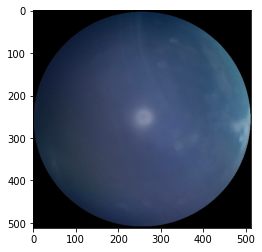

In [24]:
img = df_cat_filenames[342]
image = cv2.imread(os.path.join(img_dir_train, img))
plt.imshow(image)
print(image.shape)
print(img)

## **CREATE GRID OF EXAMPLE IMAGES**
From cataract set of image file paths, a comparitive grid to see what cataracts actually looks like is created.

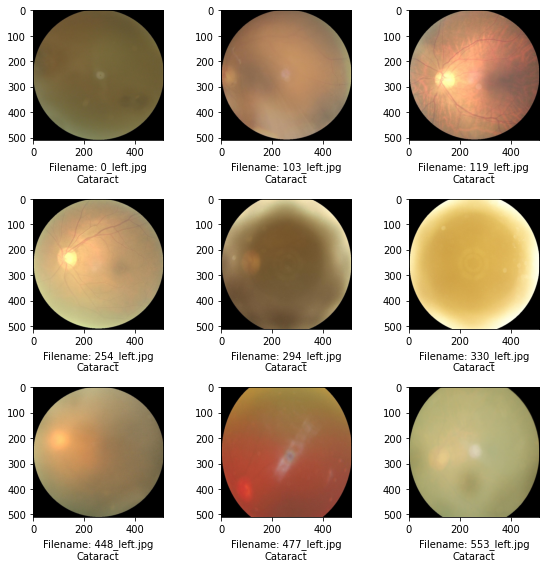

In [25]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_cat_filenames[i]
    image = cv2.imread(os.path.join(img_dir_train, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Cataract'.format(df_cat_filenames[i]))

plt.tight_layout() 


# **Gather the normal images**

We now need to gather a set of normal images. First let's see how many normal images there are available to us - we did this earlier but let's take a look again. Remember, we're working with two eyes and we noticed that some of the encoded columns don't have data for both eyes, so the whole story is not truly told. We need to look at the labeling in the keywords as that seems to be the source of truth when considering both eyes.

In [26]:
## let's place the Normal data into its own dataframe and print the number of rows

df_left_norm = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('normal')]
print(len(df_left_norm))

2855


In [27]:
## let's place the Normal data into its own dataframe and print the number of rows

df_rt_norm = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('normal')]
print(len(df_rt_norm))

2735


So if we add these up we have over 5000 images to choose from (comprised of both left and right side eye images) that are considered "normal". This is far more than we have for our 'cataract' data that had only 572 images. So, in that case let's pull an equal amount of randomly selected "normal" images.

## **COMBINE NORMAL FILENAME DATA**

In [28]:
df_norm_filenames = df_left_norm['Left-Fundus'].append(df_rt_norm['Right-Fundus'], ignore_index=True)
df_norm_filenames

0           1_left.jpg
1           8_left.jpg
2           9_left.jpg
3          14_left.jpg
4          15_left.jpg
             ...      
5585    4642_right.jpg
5586    4644_right.jpg
5587    4660_right.jpg
5588    4671_right.jpg
5589    4689_right.jpg
Length: 5590, dtype: object

# **SELECT AND CREATE A RANDOM SET**

In [29]:
## remember we're choosing 572 to equal the number of cataract images we pulled

df_norm_filenames_random = df_norm_filenames.sample(n = 572)
df_norm_filenames_random.head()

## looks like the index is out of order now that we got all the randos

2372     3063_left.jpg
3518    2743_right.jpg
5576    4571_right.jpg
5305    3225_right.jpg
3560    2788_right.jpg
dtype: object

In [30]:
## we will reset the index as well
df_norm_filenames_random = df_norm_filenames_random.reset_index(drop=True)
df_norm_filenames_random

0       3063_left.jpg
1      2743_right.jpg
2      4571_right.jpg
3      3225_right.jpg
4      2788_right.jpg
            ...      
567     3095_left.jpg
568      356_left.jpg
569     3334_left.jpg
570    3146_right.jpg
571     3065_left.jpg
Length: 572, dtype: object

## **CREATE A GRID OF NORMAL IMAGES**

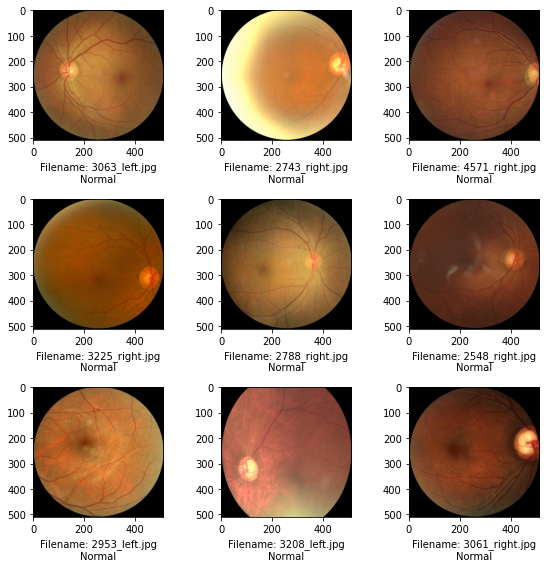

In [31]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_norm_filenames_random[i]
    image = cv2.imread(os.path.join(img_dir_train, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Normal'.format(df_norm_filenames_random[i]))

plt.tight_layout() 

In [32]:
## let's place the Normal data into its own dataframe and print the number of rows

df_left_norm = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('normal')]
print(len(df_left_norm))

2855


In [33]:
## let's place the Normal data into its own dataframe and print the number of rows

df_rt_norm = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('normal')]
print(len(df_rt_norm))

2735


So if we add these up we have over 5000 images to choose from (comprised of both left and right side eye images) that are considered "normal". This is far more than we have for our 'cataract' data that had only 572 images. So, in that case let's pull an equal amount of randomly selected "normal" images.

## **Combine normal filename data**

In [34]:
df_norm_filenames = df_left_norm['Left-Fundus'].append(df_rt_norm['Right-Fundus'], ignore_index=True)
df_norm_filenames

0           1_left.jpg
1           8_left.jpg
2           9_left.jpg
3          14_left.jpg
4          15_left.jpg
             ...      
5585    4642_right.jpg
5586    4644_right.jpg
5587    4660_right.jpg
5588    4671_right.jpg
5589    4689_right.jpg
Length: 5590, dtype: object

## Select and create a random set

In [35]:
## remember we're choosing 572 to equal the number of cataract images we pulled

df_norm_filenames_random = df_norm_filenames.sample(n = 572)
df_norm_filenames_random.head()

## looks like the index is out of order now that we got all the randos

2061     2720_left.jpg
3902    3157_right.jpg
731      2855_left.jpg
4155    3430_right.jpg
575      2679_left.jpg
dtype: object

In [36]:
## we will reset the index as well
df_norm_filenames_random = df_norm_filenames_random.reset_index(drop=True)
df_norm_filenames_random

0       2720_left.jpg
1      3157_right.jpg
2       2855_left.jpg
3      3430_right.jpg
4       2679_left.jpg
            ...      
567     2903_left.jpg
568    3267_right.jpg
569     954_right.jpg
570    3425_right.jpg
571    3075_right.jpg
Length: 572, dtype: object

### Create a grid of "normal" images

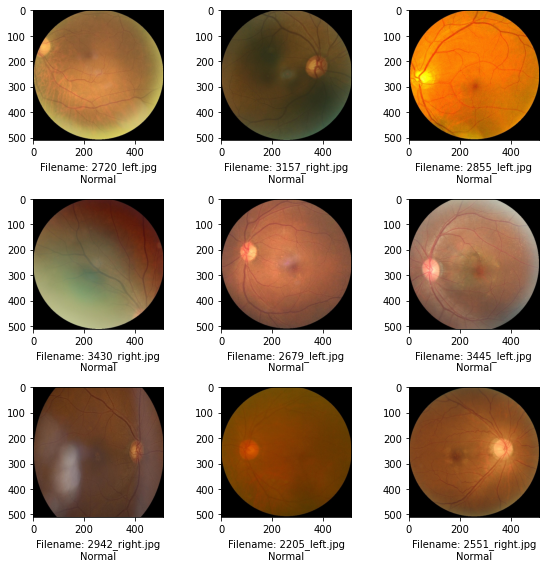

In [37]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_norm_filenames_random[i]
    image = cv2.imread(os.path.join(img_dir_train, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Normal'.format(df_norm_filenames_random[i]))

plt.tight_layout() 

# **ADD CATEGORY LABEL TO LIST**

Images will be labeled normal or cataract, in this case we will be using an image data generator that will do the **one-hot-encoding**,so we can preserve the actual word string labels.

In [38]:
df_cat_filenames = pd.DataFrame(df_cat_filenames, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_cat_filenames["label"] = "cataract"

df_cat_filenames.head()

,filename,label
0,0_left.jpg,cataract
1,103_left.jpg,cataract
2,119_left.jpg,cataract
3,254_left.jpg,cataract
4,294_left.jpg,cataract


In [39]:
df_norm_filenames_random = pd.DataFrame(df_norm_filenames_random, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_norm_filenames_random["label"] = "normal"

df_norm_filenames_random.head()

,filename,label
0,2720_left.jpg,normal
1,3157_right.jpg,normal
2,2855_left.jpg,normal
3,3430_right.jpg,normal
4,2679_left.jpg,normal


# **APPEND DATAFRAMES INTO A SINGLE DATASET**
We have both cataract and normal dataframes with labels, we need to combine them to form a single dataframe to feed into our **image generator**.

In [40]:
df_combined = df_cat_filenames.append(df_norm_filenames_random, ignore_index=True)
df_combined

,filename,label
0,0_left.jpg,cataract
1,103_left.jpg,cataract
2,119_left.jpg,cataract
3,254_left.jpg,cataract
4,294_left.jpg,cataract
...,...,...
1139,2903_left.jpg,normal
1140,3267_right.jpg,normal
1141,954_right.jpg,normal
1142,3425_right.jpg,normal


# **RANDOMIZE OUR FINAL COMBINED DATASET**

Prior to feeding this organized set of cataract and normal images we need to randomize the rows within so that when we train we will train from a random pool of samples.

In case of appending, it will result in adding a column for the old index values, which we don't want any new columns, so we'll drop the old index and allow the new dataframe to have a new one.

In [41]:
df_combined_random = df_combined.sample(frac=1).reset_index(drop=True)
df_combined_random

,filename,label
0,2203_right.jpg,cataract
1,1132_left.jpg,normal
2,3002_left.jpg,normal
3,1011_left.jpg,normal
4,2153_left.jpg,cataract
...,...,...
1139,4339_right.jpg,normal
1140,3425_right.jpg,normal
1141,132_left.jpg,normal
1142,2113_left.jpg,cataract


# **SPLIT OUR DATAFRAME INTO TEST, TRAIN, VALIDATION DATAFRAMES**

80% of the combined dataset and reserve it for the training data.

The data generator will automatically create a validation set.


In [42]:

df_train = df_combined_random.sample(frac=0.8,random_state=42)
df_train.reset_index(drop=True)

# exclude the 80% that was already chosen, the remaining 20% will go into testing
df_test = df_combined_random.drop(df_train.index)
df_test.reset_index(drop=True)

print(len(df_combined_random))
print(len(df_train))
print(len(df_test))

df_combined_random.shape

1144
915
229


(1144, 2)

# **IMAGE GENERATOR FLOW FROM DATAFRAME**

Some parameters that will perform some adjustment to the images.

In [43]:
# Install openyxl for xlsx files since Pandas no longer supports them natively
!pip install openpyxl

import random
import itertools
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,img_to_array

from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam 
#from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping


## models to import
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg19 import VGG19

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


In [44]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.20,
            rotation_range=90,
#            width_shift_range=0.2,
#            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            shear_range=0.2,
            brightness_range=[0.3,1]    
#            zoom_range=0.2
            )

## for testing we don't want to do too much augmentation, we'll just scale it.

test_datagen=ImageDataGenerator(rescale=1./255.)

In [45]:
df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

# **CONSTANTS FOR DATA PREPARATION**
For VGG pre-trained model it only accepts a **224 x 224** image size

In [46]:
img_size = 224

# **CREATE TEST, TRAIN AND VALIDATION IMAGE DATA GENERATORS**

In [47]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir_train,
x_col="filename",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

## validation set is created from the training set, 
## we set it at 20% of the training data in the previous code

valid_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir_train,
x_col="filename",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))



test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=img_dir_train,
x_col="filename",
y_col="label",
batch_size=32,
#seed=42,
shuffle=False,
class_mode="categorical",
target_size=(img_size,img_size))

Found 732 validated image filenames belonging to 2 classes.
Found 183 validated image filenames belonging to 2 classes.
Found 229 validated image filenames belonging to 2 classes.


# **IMAGE GENERATOR RESULTS**
Here are the actual data that gets created from the image generator. 
The next command splits the generator data into two numpy arrays - one with image data and one with label data.

In [48]:
train_image_data, train_labels = train_generator.next()
#train_image_data[0]
train_image_data.shape

(32, 224, 224, 3)

Let's look at the label format

In [49]:
train_labels[0]

array([1., 0.], dtype=float32)

**Augmented image** : artifical expansion of the size of the training dataset by creating modofied versions of images in dataset

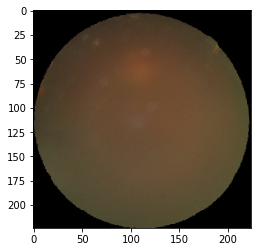

In [50]:

plt.imshow(train_image_data[0], interpolation='nearest')
plt.show()

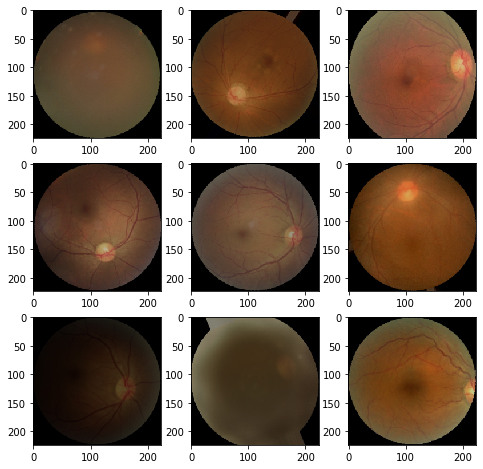

In [51]:
plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(3, 3, i + 1) 
    plt.imshow(train_image_data[i], interpolation='nearest')
    
plt.show() 

**PART A**

Keras is a powerful deep learning library that runs on top of other open-source machine learning libraries such as TensorFlow and is also open-source itself. To develop deep learning models, Keras adopts a minimal structure in Python that makes it easier to learn and quick to write. It is scalable while remaining user-friendly. The learning models Keras create are discrete components, meaning they can be combined in many ways.


# **BUILDING OUR TRANSFER LEARNING MODEL**
We load the vgg16 model.



We are doing transfer learning, we don't want the fully connected portion, so we will rip it off with the include_top FALSE option. We don't want this because we have a custom dataset that has a custom number of outputs, 2 in this case.

We will use the 'imagenet' weights since those filters / weights / kernels will help us find edges, corners, rounded areas of our images. Those are already incorporated and we can speed this process up by using some that are proven to be effective for thousands of images.

Filter - A filter or a kernel in a conv2D layer has a height and a width. They are generally smaller than the input image and so we move them across the whole image. The area where the filter is on the image is called the receptive field.

Stride - Stride is a parameter of the neural network's filter that modifies the amount of movement over the image or video.

Padding - Padding is an operation to increase the size of the input data.

Max pooling - Pooling operation that selects the maximum element from the region of the feature map covered by the filter. Thus, the output after max-pooling layer would be a feature map containing the most prominent features of the previous feature map.

We will **drop 50% of the perceptrons** during the final layer to avoid overfitting.

We will use the **ADAM gradient descent optimizer** as well.



Implementation of activation function using ReLU and seLU


1. An activation function is a function that is added into an artificial neural network in order to help the network learn complex patterns in the data.

2. Scaled Exponential Linear Units, or SELUs, are activation functions that induce self-normalizing properties.

3. The purpose of applying the rectifier function is to increase the non-linearity in our images. The reason we want to do that is that images are naturally non-linear. When you look at any image, you'll find it contains a lot of non-linear features (e.g. the transition between pixels, the borders, the colors, etc.).

4. The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance.




Implementation of cost function which is binary cross entrophy

A cost function is a measure of "how good" a neural network did with respect to it's given training sample and the expected output. It also may depend on variables such as weights and biases. A cost function is a single value, not a vector, because it rates how good the neural network did as a whole.
Binary cross entropy compares each of the predicted probabilities to actual class output which can be either 0 or 1. It then calculates the score that penalizes the probabilities based on the distance from the expected value. That means how close or far from the actual value


Implementation of Gradient Estimation by using adamn 

What is a gradient in neural networks?

The gradient is a numeric calculation allowing us to know how to adjust the parameters of a network in such a way that its output deviation is minimized.
A gradient is a derivative of a function that has more than one input variable. Known as the slope of a function in mathematical terms, the gradient simply measures the change in all weights with regard to the change in error.

1. Adam is an adaptive learning rate method, which means, it computes individual learning rates for different parameters. Its name is derived from adaptive moment estimation, and the reason it’s called that is because Adam uses estimations of first and second moments of gradient to adapt the learning rate for each weight of the neural network

2. Adam is different to classical stochastic gradient descent.

3. Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.

4. A learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds.

# **CREATE CHECK POINT AND EARLY STOP**

**Check point** allows us to monitor the acuraccy and perform some task, in this case we will save the model as a file.

**Early stop** will monitor accuracy for a 'patience' parameter and if there is no improvement it will stop.

# **CONSTANTS FOR OUR TRAINING RUN**

**SPE** is 'steps per epoch'

**n_val_steps** is 'number of validation steps'

Changing the number of epochs initialization and its affect on network plateau

In [52]:
batch_size = 32
n_spe = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size
n_epochs = 10

print(n_spe,n_val_steps)

22 5


In general, neural networks are trained by gradient descent type optimization methods, or a stochastic variant thereof. In practice, such methods result in the loss function decreases rapidly at the beginning of training but then, after a relatively small number of steps, significantly slow down. The loss may even appear to stagnate over the period of a large number of epochs, only to then suddenly start to decrease fast again for no apparent reason. This so-called plateau phenomenon manifests itself in many learning tasks. 

The learning rate hyperparameter determines how fast the model learns. When the weights are updated, such as at the end of a batch of training examples, it controls the amount of allocated error that is used to update the model’s weights.  

Learning rate annealing is the most widely used approach to solve network plateau problem, which proposes starting with a reasonably high learning rate and gradually reducing it during training. The idea behind this method is that we want to get from the initial parameters to a range of excellent parameter values quickly, but we also want a learning rate low enough to explore the deeper, but narrower regions of the loss function. 

Thus we have used a optimum learning rate in our checkpoints.


We are using 2 models
1. VGG 19
2. VGG 16

# **VGG19 model with sequential**

In [53]:
image_size = 224

The network initialization and its effect on accuracy.

In [54]:
#network intialization used here is glorot uniform
#activation function sigmoid

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense



vgg19 = keras.applications.vgg19.VGG19(input_shape=(224, 224, 3),
                                       weights='imagenet',
                                       include_top=False)


# add new dense layers at the top
x = keras.layers.Flatten()(vgg19.output)
x = keras.layers.Dense(1024, activation='sigmoid')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='sigmoid', kernel_initializer='glorot_uniform')(x)

## remember we are using 2 outputs only
predictions = keras.layers.Dense(2, activation='softmax')(x)

# define and compile model
model = keras.Model(inputs=vgg19.inputs, outputs=predictions)
for layer in vgg19.layers:
    layer.trainable = False
    
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])




80150528/80134624 [==============================] - 1s 0us/step


In [55]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [56]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1
                            )

earlystop = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=3, 
                      verbose=1, 
                      mode='auto')

In [57]:

history = model.fit(train_generator,
                        steps_per_epoch=n_spe,
                        validation_data=valid_generator,
                        validation_steps=n_val_steps,
                        epochs=n_epochs,
                        callbacks=[checkpoint,earlystop])

Epoch 1/10
22/22 [==============================] - ETA: 0s - loss: 0.8134 - accuracy: 0.4600 
Epoch 00001: val_accuracy improved from -inf to 0.44375, saving model to vgg19.h5
22/22 [==============================] - 508s 23s/step - loss: 0.8134 - accuracy: 0.4600 - val_loss: 0.7471 - val_accuracy: 0.4437
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: 0.6939 - accuracy: 0.5214 
Epoch 00002: val_accuracy improved from 0.44375 to 0.81250, saving model to vgg19.h5
22/22 [==============================] - 494s 23s/step - loss: 0.6939 - accuracy: 0.5214 - val_loss: 0.6819 - val_accuracy: 0.8125
Epoch 3/10
22/22 [==============================] - ETA: 0s - loss: 0.6828 - accuracy: 0.5914 
Epoch 00003: val_accuracy did not improve from 0.81250
22/22 [==============================] - 490s 22s/step - loss: 0.6828 - accuracy: 0.5914 - val_loss: 0.6750 - val_accuracy: 0.6250
Epoch 4/10
22/22 [==============================] - ETA: 0s - loss: 0.6614 - accuracy: 0.6757 
Epoch

In [58]:
#Saving and loading model

from keras.models import load_model
model = load_model('./vgg19.h5')

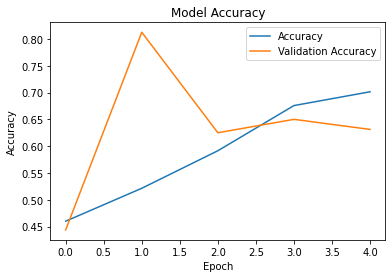

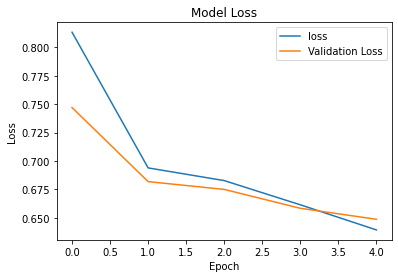

In [59]:
#Plotting accuracy vs loss graph

plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

## **Hyperparameter Tuning**

In [60]:
batch_size = 64
n_spe = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size
n_epochs = 20

print(n_spe,n_val_steps)

11 2


The network initialization and its effect on accuracy.

In [67]:
#network initialization changed to HeUniform
#and activation function is sigmoid

from tensorflow.keras import initializers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
#model = Sequential()


vgg19 = keras.applications.vgg19.VGG19(input_shape=(224, 224, 3),
                                       weights='imagenet',
                                       include_top=False)


# add new dense layers at the top
x = keras.layers.Flatten()(vgg19.output)
x = keras.layers.Dense(1024, activation='sigmoid')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='sigmoid', kernel_initializer=initializers.HeUniform(seed=None))(x)


## remember we are using 2 outputs only
predictions = keras.layers.Dense(2, activation='softmax')(x)

# define and compile model
model = Sequential()
model = keras.Model(inputs=vgg19.inputs, outputs=predictions)
for layer in vgg19.layers:
    layer.trainable = False
    
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [68]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1,learning_rate = 0.5
                            )

earlystop = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=3, 
                      verbose=1, 
                      mode='auto')

In [69]:
hist = model.fit(train_generator,
                        steps_per_epoch=n_spe,
                        validation_data=valid_generator,
                        validation_steps=n_val_steps,
                        epochs=n_epochs,
                        shuffle=True,
                        workers=5,
                        use_multiprocessing=True,
                        callbacks=[checkpoint,earlystop])

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 0.8473 - accuracy: 0.5345 
Epoch 00001: val_accuracy improved from -inf to 0.56250, saving model to vgg19.h5
11/11 [==============================] - 251s 22s/step - loss: 0.8473 - accuracy: 0.5345 - val_loss: 0.7320 - val_accuracy: 0.5625
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.7013 - accuracy: 0.5455 
Epoch 00002: val_accuracy did not improve from 0.56250
11/11 [==============================] - 294s 27s/step - loss: 0.7013 - accuracy: 0.5455 - val_loss: 0.7855 - val_accuracy: 0.4062
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.6818 - accuracy: 0.5852 
Epoch 00003: val_accuracy improved from 0.56250 to 0.79688, saving model to vgg19.h5
11/11 [==============================] - 253s 23s/step - loss: 0.6818 - accuracy: 0.5852 - val_loss: 0.6624 - val_accuracy: 0.7969
Epoch 4/20
11/11 [==============================] - ETA: 0s - loss: 0.6593 - accuracy: 0.6494 
Epoch

In [70]:
#Saving and loading model

from keras.models import load_model
model = load_model('./vgg19.h5')

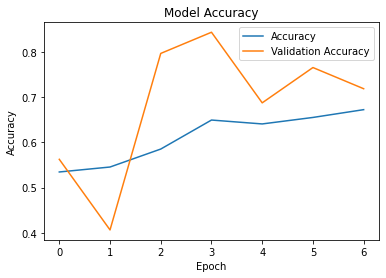

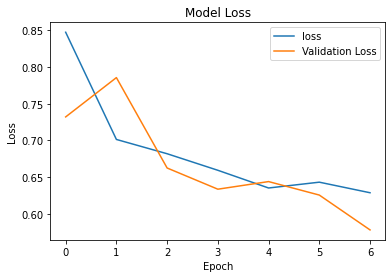

In [71]:
#Plotting accuracy vs loss graph

plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

# **VGG16**

In [72]:
#Here, we are using selu activation function
#network intialization is glorot_uniform

vgg16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3),
                                       weights='imagenet',
                                       include_top=False)


# add new dense layers at the top
x = keras.layers.Flatten()(vgg16.output)
x = keras.layers.Dense(1024, activation='selu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='selu', kernel_initializer='glorot_uniform')(x)

## remember we are using 2 outputs only
predictions = keras.layers.Dense(2, activation='softmax')(x)

# define and compile model
model = keras.Model(inputs=vgg16.inputs, outputs=predictions)
for layer in vgg16.layers:
    layer.trainable = False
    
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

58900480/58889256 [==============================] - 0s 0us/step


# **Hyperparameter tuning**

In [73]:
#epoch size to 30 and batch size 32

batch_size = 32
n_spe = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size
n_epochs = 30

print(n_spe,n_val_steps)

22 5


In [75]:
#changing the learning rate to 0.5

checkpoint = ModelCheckpoint("vgg16_1.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1,learning_rate = 0.5
                            )

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=3, 
                      verbose=1, 
                      mode='auto')

In [76]:
#SELU


hist = model.fit(train_generator,
                        steps_per_epoch=n_spe,
                        validation_data=valid_generator,
                        validation_steps=n_val_steps,
                        epochs=n_epochs,
                        shuffle=True,
                        workers=5,
                        use_multiprocessing=True,
                        callbacks=[checkpoint,early])



Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 3.5387 - accuracy: 0.6357 
Epoch 00001: val_accuracy improved from -inf to 0.81875, saving model to vgg16_1.h5
22/22 [==============================] - 406s 18s/step - loss: 3.5387 - accuracy: 0.6357 - val_loss: 0.4577 - val_accuracy: 0.8188
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 1.0270 - accuracy: 0.7188 
Epoch 00002: val_accuracy improved from 0.81875 to 0.92500, saving model to vgg16_1.h5
22/22 [==============================] - 406s 18s/step - loss: 1.0270 - accuracy: 0.7188 - val_loss: 0.3151 - val_accuracy: 0.9250
Epoch 3/30
22/22 [==============================] - ETA: 0s - loss: 0.5324 - accuracy: 0.7914 
Epoch 00003: val_accuracy did not improve from 0.92500
22/22 [==============================] - 408s 18s/step - loss: 0.5324 - accuracy: 0.7914 - val_loss: 0.3303 - val_accuracy: 0.8625
Epoch 4/30
22/22 [==============================] - ETA: 0s - loss: 0.4375 - accuracy: 0.8086 
E

In [77]:
#Saving and loading model

from keras.models import load_model
model = load_model('./vgg16_1.h5')

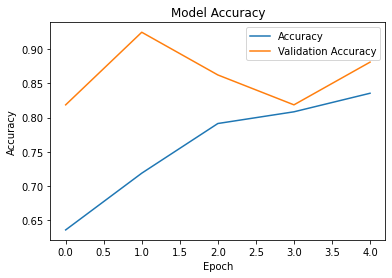

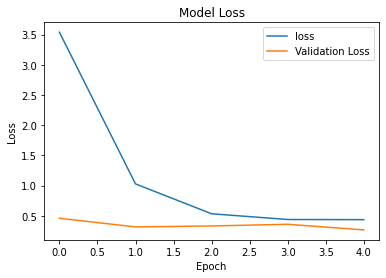

In [78]:
#Plotting accuracy vs loss graph

plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

## **Hyperparameter tuning**

Training the model with different activation function which is relu to improve accuracy

In [79]:
#import VGG16 library and add preprocessing layer to the front of VGG. 
vgg16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3),
                                       weights='imagenet',
                                       include_top=False)

# add new dense layers at the top
x = keras.layers.Flatten()(vgg16.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform')(x)

## remember we are using 2 outputs only
predictions = keras.layers.Dense(2, activation='softmax')(x)

# define and compile model
model = keras.Model(inputs=vgg16.inputs, outputs=predictions)
for layer in vgg16.layers:
    layer.trainable = False
    
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [80]:
batch_size = 20
n_spe = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size
n_epochs = 10

print(n_spe,n_val_steps)

36 9


In [81]:
checkpoint = ModelCheckpoint("vgg16_1.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1,learning_rate = 0.5
                            )

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=3, 
                      verbose=1, 
                      mode='auto')

In [83]:
#RELU with 0.5 learning rate, batch size 20 and epoch 10

hist = model.fit(train_generator,
                        steps_per_epoch=n_spe,
                        validation_data=valid_generator,
                        validation_steps=n_val_steps,
                        epochs=n_epochs,
                        shuffle=True,
                        workers=5,
                        use_multiprocessing=True,
                        callbacks=[checkpoint,early])

Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 1.2320 - accuracy: 0.6429 
Epoch 00001: val_accuracy improved from -inf to 0.83871, saving model to vgg16_1.h5
36/36 [==============================] - 682s 19s/step - loss: 1.2320 - accuracy: 0.6429 - val_loss: 0.3754 - val_accuracy: 0.8387
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 0.4099 - accuracy: 0.8278 
Epoch 00002: val_accuracy improved from 0.83871 to 0.84229, saving model to vgg16_1.h5
36/36 [==============================] - 683s 19s/step - loss: 0.4099 - accuracy: 0.8278 - val_loss: 0.3243 - val_accuracy: 0.8423
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 0.3493 - accuracy: 0.8619 
Epoch 00003: val_accuracy improved from 0.84229 to 0.88889, saving model to vgg16_1.h5
36/36 [==============================] - 684s 19s/step - loss: 0.3493 - accuracy: 0.8619 - val_loss: 0.2456 - val_accuracy: 0.8889
Epoch 4/10
36/36 [==============================] - ETA: 0s - lo

# **LOAD AND SAVED THE BEST MODEL**

In [91]:
from keras.models import load_model
model = load_model('./vgg16_1.h5')

# **PLOT ACCURACY VERSUS LOSS**

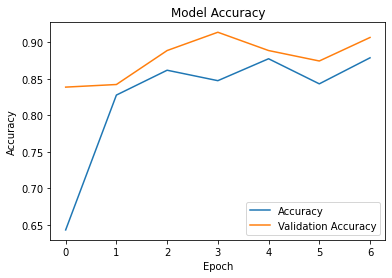

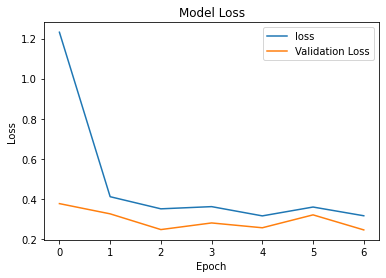

In [92]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

# **Conclusion**



The models VGG16 and VGG 19 are implemented in this workbook. The model is trained so as to obtain the best classification report.

VGG16 [Visual Geometry Group — 16] is one of the simplest CNN architectures used in ImageNet competitions. VGG16 is structured as 2Conv — 1Maxpool — 2Conv — 1Maxpool — 3Conv — 1Maxpool — 3Conv — 1Maxpool — 3Conv — 1Maxpool — 1FC — 1FC — 1FC.

VGG-19 architecture is very much similar to VGG-16.In addition to it there are 3 additional convolutional layers for the VGG-16 network. The architecture is as follows: 2Conv — 1Maxpool — 2Conv — 1Maxpool — 4Conv — 1Maxpool — 4Conv — 1Maxpool — 4Conv — 1Maxpool — 1FC — 1FC — 1FC.

Transfer learning is implemented as it saves training time and gives better performance. 

Various activation functions such as ReLU and SeLU are used to introduce non linearity to the training model. Cost function is calculated using Binary cross entropy. ADAMN is used as gradient descent for obtaining the global local minima for the training model.

Hyperparameter tuning is achieved for both the models by changing the batch size and the epochs. Effect on learning rate on the models is also implemented in the study.

Visualization techniques for EDA and PLOT ACCURACY graphs are implemented for better understanding of the results.

Thus, the cataract images from the dataset are classified with accuracy of 
0.9068 in vgg16 and accuracy of 0.718 in vgg19 models respectively.

# **MAKE OUR PREDICTIONS WITH predict.generator**

We need to reset the test generator so that we aren't feeding any old image data further down the line.

The prediction output is only a set of categorical labels of 0 and 1. 
Here, **Cataract is 0 and normal is 1.** 

The prediction output is NOT image data.

In [93]:
test_generator.reset()

In [94]:
pred = model.predict_generator(test_generator,verbose=1,steps=test_generator.samples/batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


11/11 [==============================] - 104s 9s/step


# **PREDICTION RAW DATA**

In [95]:
print(pred[0:10])

[[9.2681212e-06 9.9999070e-01]
 [1.8466093e-03 9.9815339e-01]
 [9.8433220e-01 1.5667818e-02]
 [9.9212414e-01 7.8758271e-03]
 [9.9359351e-01 6.4065377e-03]
 [2.0954524e-06 9.9999785e-01]
 [1.7529322e-09 1.0000000e+00]
 [5.6426030e-02 9.4357389e-01]
 [9.9507254e-01 4.9274457e-03]
 [9.9207580e-01 7.9241870e-03]]


# **CONVERT RAW PREDICTION DATA**

Converting the raw data into 1's and 0's. 

Argmax will do this now.

In [96]:
predicted_class_idx=np.argmax(pred,axis=1)

## print the same 10 rows

print(predicted_class_idx[0:10])

[1 1 0 0 0 1 1 1 0 0]


# **EVALUATE MODEL'S ACCURACY**

In [97]:
model.evaluate(test_generator,use_multiprocessing=True,workers=10)

8/8 [==============================] - 111s 13s/step - loss: 0.2227 - accuracy: 0.9127


[0.22266843914985657, 0.9126637578010559]

Here, Loss is estiamted to be **0.2227** and Accuracy is **0.9127**

# **CONVERT ONE-HOT CATEGORY LABELS TO TEXT LABELS**
Eventually need the actual text names , so we convert 0 and 1 back to label names.



In [98]:
valid_generator.class_indices.items()

dict_items([('cataract', 0), ('normal', 1)])

In [99]:
valid_labels = dict((value,key) for key,value in valid_generator.class_indices.items())
pred_labels = [valid_labels[key] for key in predicted_class_idx]

# **BUILD A NEW DATAFRAME**

In [100]:
filenames = test_generator.filenames
prediction_df = pd.DataFrame({'Filename': filenames,'Prediction': pred_labels})
prediction_df.head()

,Filename,Prediction
0,1132_left.jpg,normal
1,896_left.jpg,normal
2,2163_left.jpg,cataract
3,2098_left.jpg,cataract
4,2218_right.jpg,cataract


# **VERIFY PREDICTION DATAFRAME RESULTS**
Verification of prediction data allignmenmt with the test filename, row and diagnosis.


In [101]:
prediction_df.iloc[35]

Filename      2120_right.jpg
Prediction          cataract
Name: 35, dtype: object

# **COMPARE THAT SAME ROW TO OUR TEST GENERATOR DATA**

In [102]:
print(test_generator.filenames[35])
print(test_generator.labels[35])

2120_right.jpg
0


# **PREDICTION VS TEST IMAGE GRID**
Here are the results of our prediction vs test images.

In test data items, the image array and the encoded image category are renamed.

In [103]:
test_image_data, test_labels = test_generator.next()

In [104]:
print(test_image_data.shape)
print(test_labels.shape)

(32, 224, 224, 3)
(32, 2)


In [105]:
z = 0
#test filename

test_file_names=test_generator.filenames[z]
print(test_file_names)

test_labels_example=test_generator.labels[z]
print(test_labels_example)

pred_labels[z]

1132_left.jpg
1


'normal'

# **PLOT OUR COMPARISON GRID**

The data generator encodes categories whereby cataract = 0 and normal = 1. 

Since we are using image generators we will only be able to gather 32 images at a time since this is the batch size we set. 

If we increase our batch size, the generator will gather more images and send them through the fit function during training

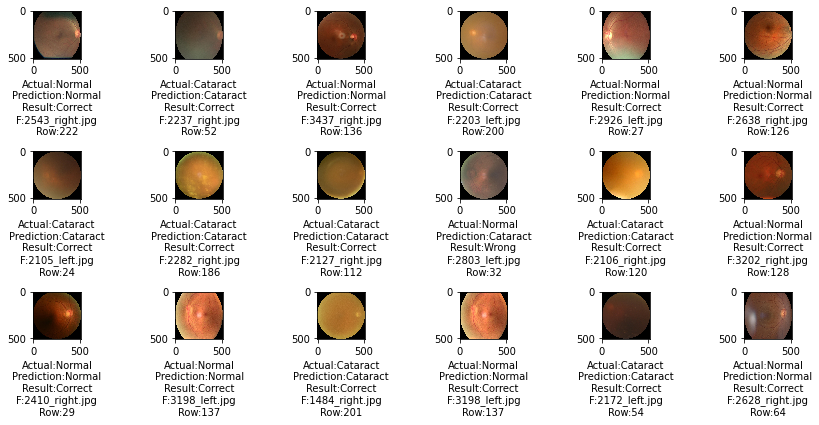

In [106]:
plt.figure(figsize=(12,6))
for i in range(18):
    sample = random.choice(range(test_generator.samples))
#    print(str(sample))
    img = test_generator.filenames[sample]
    image = cv2.imread(os.path.join(img_dir_train, img))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    category = test_generator.labels[sample]
    pred_category = pred_labels[sample]

#    sample = random.choice(range(0,test_generator.samples))    
#    image = test_image_data[sample]
#    category = test_class_idx[sample]
#    pred_category = pred_labels[sample]
           
    
    if category== 1:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== "normal":
        pred_label = "Normal"
    else:
        pred_label = "Cataract"

    if label == pred_label:
        result = "Correct"
    else:
        result = "Wrong"

        
    plt.subplot(3,6,i+1)
    plt.imshow(image_rgb, interpolation='nearest')
    plt.xlabel("Actual:{}\nPrediction:{}\nResult:{}\nF:{}\nRow:{}".format(label,
                                                                          pred_label,
                                                                          result,
                                                                          test_generator.filenames[sample],
                                                                          sample))
plt.tight_layout() 

# **CLASSIFICATION REPORT**

In [107]:
print('Classification Report')
target_names = ['Cataract', 'Normal']
print(classification_report(test_generator.classes, predicted_class_idx, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    Cataract       0.91      0.90      0.90       106
      Normal       0.91      0.93      0.92       123

    accuracy                           0.91       229
   macro avg       0.91      0.91      0.91       229
weighted avg       0.91      0.91      0.91       229



# **CONFUSION MATRIX**

In [108]:
cm = confusion_matrix(test_generator.labels, predicted_class_idx)
print('Confusion Matrix')
cm

Confusion Matrix


array([[ 95,  11],
       [  9, 114]])

In [109]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [110]:
cm_plot_labels = ['cataract','normal']

Confusion matrix, without normalization
[[ 95  11]
 [  9 114]]


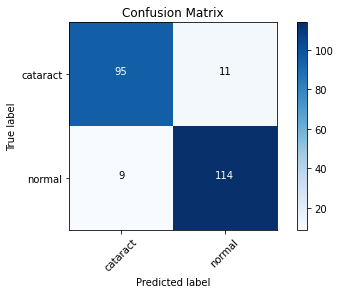

In [111]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')


# **REFERENCES**

https://koushik1102.medium.com/transfer-learning-with-vgg16-and-vgg19-the-simpler-way-ad4eec1e2997

https://www.kaggle.com/andrewmvd/ocular-disease-recognition-odir5k/code?datasetId=611716&sortBy=voteCount

https://www.kaggle.com/klmsathishkumar/cataract-prediction

https://www.youtube.com/results?search_query=vgg16+image+classification

 https://www.youtube.com/watch?v=cxPAvoIbsIk

https://keras.io/api/layers/activations/https://www.youtube.com/watch?v=mRVTKrbRYi0

# **LICENSING**

**Copyright 2021 Sharmadha Parthiban**

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

